In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-classification-finetuning/sample_submission.csv
/kaggle/input/llm-classification-finetuning/train.csv
/kaggle/input/llm-classification-finetuning/test.csv
/kaggle/input/deberta-v3-base/pytorch/default/1/config.json
/kaggle/input/deberta-v3-base/pytorch/default/1/weights.safetensors
/kaggle/input/deberta-v3-base/pytorch/default/1/tokenizer/spm.model
/kaggle/input/deberta-v3-base/pytorch/default/1/tokenizer/tokenizer.json
/kaggle/input/deberta-v3-base/pytorch/default/1/tokenizer/tokenizer_config.json
/kaggle/input/deberta-v3-base/pytorch/default/1/tokenizer/special_tokens_map.json
/kaggle/input/deberta-v3-base/pytorch/default/1/tokenizer/added_tokens.json


In [2]:
# 1. 套件匯入
import os
import pandas as pd
import torch
from datasets import Dataset
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import shutil

2025-05-09 12:44:09.301542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746794649.502490      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746794649.558655      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用裝置：", device)

使用裝置： cuda


In [4]:
# 2. 準備模型目錄：複製權重、tokenizer 到 /kaggle/working
model_src = "/kaggle/input/deberta-v3-base/pytorch/default/1"
model_dst = "/kaggle/working/deberta"

os.makedirs(f"{model_dst}/tokenizer", exist_ok=True)
shutil.copy(f"{model_src}/config.json", f"{model_dst}/config.json")
shutil.copy(f"{model_src}/weights.safetensors", f"{model_dst}/model.safetensors")
shutil.copytree(f"{model_src}/tokenizer", f"{model_dst}/tokenizer", dirs_exist_ok=True)

'/kaggle/working/deberta/tokenizer'

In [5]:
# 4. 讀取資料
train_df = pd.read_csv("/kaggle/input/llm-classification-finetuning/train.csv")
test_df = pd.read_csv("/kaggle/input/llm-classification-finetuning/test.csv")

In [6]:
# 5 整理資料格式
train_df["text"] = train_df.apply(
    lambda row: f"{row['prompt']}\n\n[A] {row['response_a']}\n\n[B] {row['response_b']}", axis=1
)
train_df["label"] = train_df[["winner_model_a", "winner_model_b", "winner_tie"]].values.argmax(axis=1)

test_df["text"] = test_df.apply(
    lambda row: f"{row['prompt']}\n\n[A] {row['response_a']}\n\n[B] {row['response_b']}", axis=1
)

In [7]:

# 6. 載入 tokenizer 與 model（離線）
tokenizer = DebertaV2Tokenizer.from_pretrained(f"{model_dst}/tokenizer")
model = DebertaV2ForSequenceClassification.from_pretrained(model_dst, num_labels=3).to(device)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/working/deberta and are newly initialized: ['classifier.bias', 'classifier.weight', 'deberta.embeddings.LayerNorm.bias', 'deberta.embeddings.LayerNorm.weight', 'deberta.embeddings.word_embeddings.weight', 'deberta.encoder.LayerNorm.bias', 'deberta.encoder.LayerNorm.weight', 'deberta.encoder.layer.0.attention.output.LayerNorm.bias', 'deberta.encoder.layer.0.attention.output.LayerNorm.weight', 'deberta.encoder.layer.0.attention.output.dense.bias', 'deberta.encoder.layer.0.attention.output.dense.weight', 'deberta.encoder.layer.0.attention.self.key_proj.bias', 'deberta.encoder.layer.0.attention.self.key_proj.weight', 'deberta.encoder.layer.0.attention.self.query_proj.bias', 'deberta.encoder.layer.0.attention.self.query_proj.weight', 'deberta.encoder.layer.0.attention.self.value_proj.bias', 'deberta.encoder.layer.0.attention.self.value_proj.weight', 'deberta.encoder.layer.0.intermedi

In [8]:
# 7. Tokenization
train_ds = Dataset.from_pandas(train_df[["text", "label"]])
test_ds = Dataset.from_pandas(test_df[["text"]])

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=512)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

Map:   0%|          | 0/57477 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [9]:
os.environ["WANDB_DISABLED"] = "true"
# 匯入後手動清掉 callbacks 裡的 wandb
from transformers import TrainerCallback
from transformers.integrations import WandbCallback

In [10]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",         # 模型儲存路徑
    do_train=True,                  # 啟用訓練
    do_eval=True,                   # 啟用驗證
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",          # 日誌儲存路徑
    logging_steps=50,
    save_steps=9999999,            # 關閉自動儲存（因為不支援 save_strategy）
    eval_steps=1,                  # 每輪做 eval（模擬 evaluation_strategy="epoch"）
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [11]:
# ✅ 建立 Trainer 前先註冊時排除 WandB
class NoOpCallback(TrainerCallback):
    def on_log(self, *args, **kwargs):
        pass  # 不做任何紀錄

In [12]:
# 9. Trainer & metrics
def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=train_ds.shuffle(seed=42).select(range(1000)),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_19/96330349.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
# 10. 訓練模型
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,1.115800
100,1.120400
150,1.114700
200,1.119300
250,1.106900
300,1.105300
350,1.103400
400,1.097900
450,1.109200
500,1.098400


TrainOutput(global_step=10779, training_loss=1.0586168471620458, metrics={'train_runtime': 14018.7836, 'train_samples_per_second': 12.3, 'train_steps_per_second': 0.769, 'total_flos': 4.536972336379392e+16, 'train_loss': 1.0586168471620458, 'epoch': 3.0})

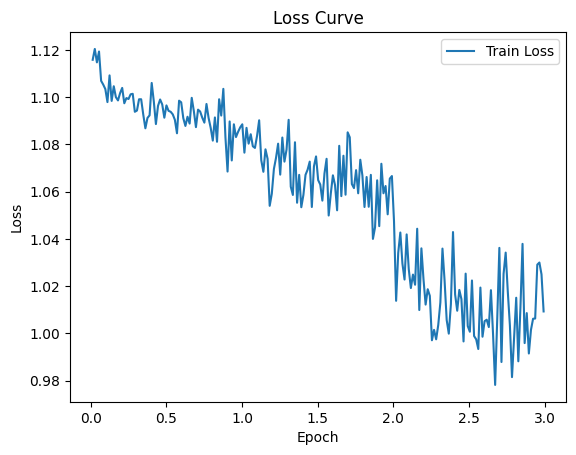

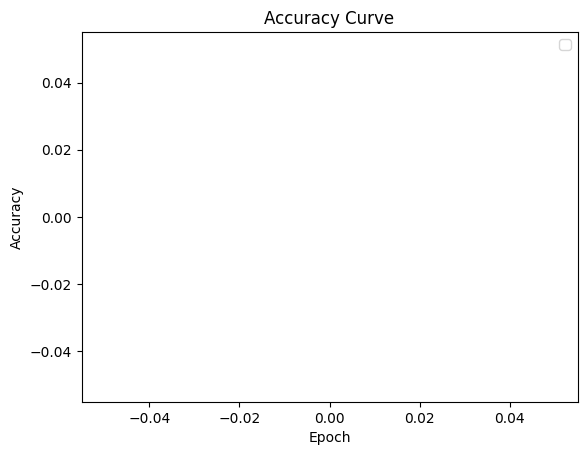

In [14]:
# 11. Loss 與 Accuracy 圖表
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc = [], [], []

for entry in logs:
    if "loss" in entry and "epoch" in entry:
        train_loss.append((entry["epoch"], entry["loss"]))
    if "eval_loss" in entry:
        eval_loss.append((entry["epoch"], entry["eval_loss"]))
        eval_acc.append((entry["epoch"], entry["eval_accuracy"]))

plt.figure()
plt.plot(*zip(*train_loss), label="Train Loss")
plt.plot(*zip(*eval_loss), label="Eval Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve"); plt.legend()
plt.show()

plt.figure()
plt.plot(*zip(*eval_acc), label="Eval Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curve"); plt.legend()
plt.show()

In [15]:
# 12. 推論與 submission
predictions = trainer.predict(test_ds)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

submission = pd.DataFrame({
    "id": test_df["id"],
    "winner_model_a": probs[:, 0],
    "winner_model_b": probs[:, 1],
    "winner_model_tie": probs[:, 2],
})
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv 已儲存！")

✅ submission.csv 已儲存！
